# feature extraction for logistic ADNI models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [3]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [4]:
# IDs = ADNI_ds.getIDs()

In [5]:
# len(IDs)

### Loading ADNI predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
model_name = "CHAL_based_SSN_Ensemble"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [02:21<00:00,  2.05it/s]


In [9]:
model_name_for_pred = "CHAL_based_SSN_Ensemble_Mean"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [02:20<00:00,  2.07it/s]


In [10]:
key_order

['ent', 'pred', 'seg', 'var']

In [11]:
ID = list(output_maps_for_umaps.keys())[2]

In [12]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

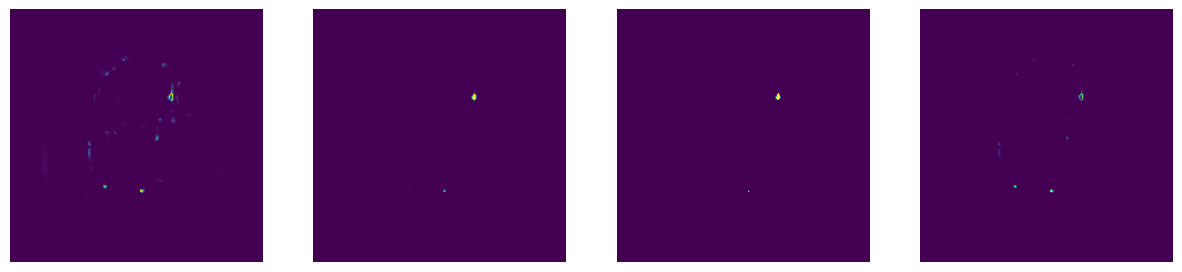

In [13]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

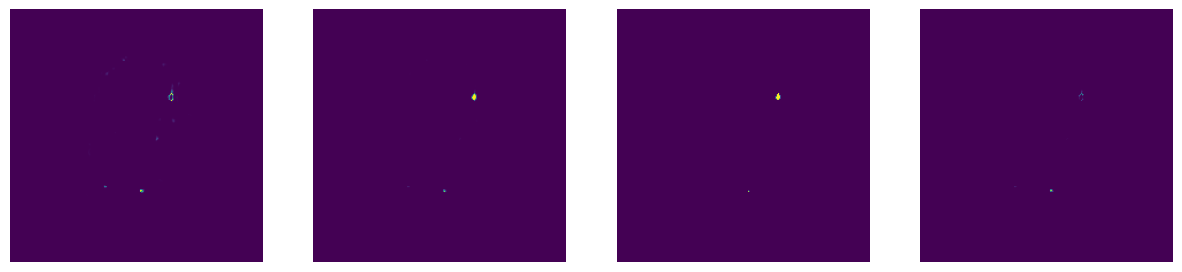

In [14]:
ent, pred, seg, var = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [15]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
var_voxels = var[var > t/10]

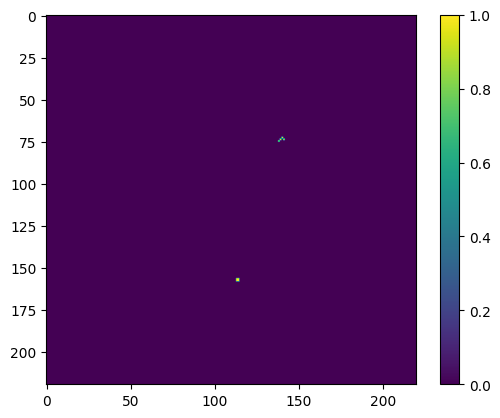

In [16]:
plt.imshow(var[islice]>0.01)
plt.colorbar()

<AxesSubplot: ylabel='Density'>

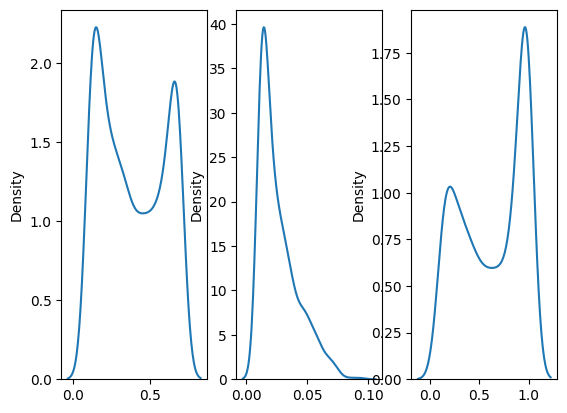

In [17]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [18]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [19]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [20]:
histogram_distribution(ent_voxels, 20)

tensor([0.1347, 0.0911, 0.0723, 0.0546, 0.0502, 0.0546, 0.0425, 0.0475, 0.0464,
        0.0342, 0.0326, 0.0364, 0.0359, 0.0342, 0.0359, 0.0425, 0.0392, 0.0447,
        0.0706, 0.0000])

In [21]:
# counts, counts.sum()

<AxesSubplot: ylabel='Count'>

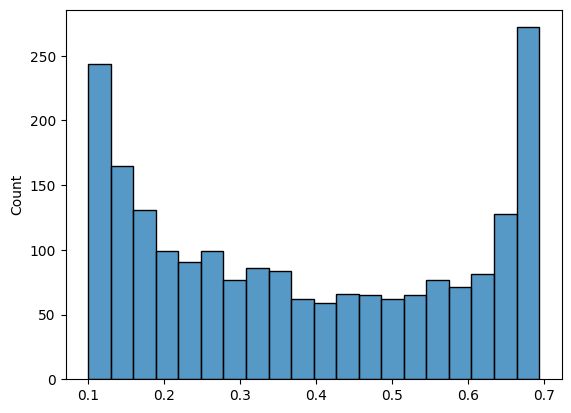

In [22]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [23]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [24]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [25]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((220, 220))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [26]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [27]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([58, 220, 220])

In [28]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:45<00:00,  6.37it/s]


In [29]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([58, 220, 220]), tensor(33))

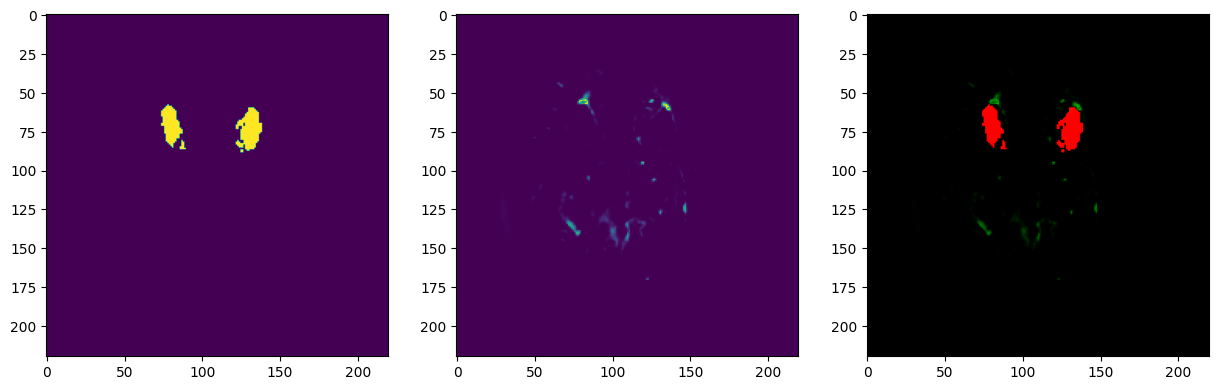

In [30]:
islice = 26
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[0].shape[1:], 3)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [31]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [32]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [33]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [34]:
import cc3d

In [35]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [36]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [37]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [38]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [39]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [40]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [41]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [42]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [43]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [44]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [45]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [46]:
# joint_counts.shape

In [47]:
# plt.imshow(joint_counts); plt.colorbar()

In [48]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [49]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [50]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [51]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [52]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [53]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [54]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [55]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "var", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            elif input_type == "var":
                umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
                ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
                maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
        

  0%|                                                                                                                                                                 | 0/290 [00:00<?, ?it/s]

ADNI_002_S_0729_20110816


/tmp/ipykernel_3633260/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_3633260/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


218 198
164 138
126 84
167 82
218 100
297 111
189 164
175 124
246 131
387 158
367 134
159 58
63 24
55 14
57 11
59 9
54 0


  0%|▌                                                                                                                                                      | 1/290 [00:22<1:48:49, 22.59s/it]

52 0
ADNI_002_S_1155_20111222
504 493
351 337
210 193
140 123
109 91
77 56
407 394
318 303
213 196
133 114
99 81


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)


77 47
29 12
27 10
27 9
23 5


  1%|█                                                                                                                                                      | 2/290 [00:30<1:07:08, 13.99s/it]

20 0
20 0
ADNI_002_S_1261_20110314
363 346
246 228
166 146
132 107
107 81
94 66
318 300
233 212
191 167
133 108
132 103
93 57
29 10
28 8
27 5
27 4
29 0


  1%|█▌                                                                                                                                                       | 3/290 [00:37<52:31, 10.98s/it]

26 0
ADNI_002_S_1280_20110504
240 208
189 148
197 128
225 111
246 114
286 126
239 192
250 169
272 159
294 141
222 125
150 59
64 18
60 12
62 10
61 6


  1%|██                                                                                                                                                       | 4/290 [00:47<50:02, 10.50s/it]

58 0
55 0
ADNI_002_S_2010_20101022
153 137
134 115
99 77
89 65
82 56
76 49
134 116
128 106
101 77
91 65
80 51
52 35
33 14
27 8
22 3


  2%|██▋                                                                                                                                                      | 5/290 [00:51<38:52,  8.18s/it]

19 0
20 0
18 0
ADNI_002_S_4213_20111205
436 416
285 262
141 113
109 79
95 60
94 49
343 321
274 243
195 161
116 78
100 64
55 28
33 12
29 8
25 3
23 1
22 0


  2%|███▏                                                                                                                                                     | 6/290 [00:58<36:22,  7.69s/it]

22 0
ADNI_002_S_4225_20111226
489 453
319 276
224 176
204 147
198 121
199 109
403 362
308 260
262 190
262 164
222 130
136 79
97 38
85 23
78 14
78 8
71 0


  2%|███▋                                                                                                                                                     | 7/290 [01:08<39:56,  8.47s/it]

71 0
ADNI_002_S_4229_20111221
539 511
370 336
248 211
227 168
229 131
246 127
449 415
337 294
322 227
294 186
261 166
140 98
61 23
57 19
50 11
47 4
48 0


  3%|████▏                                                                                                                                                    | 8/290 [01:19<43:14,  9.20s/it]

40 0
ADNI_002_S_4237_20110926
451 422
366 330
265 226
225 182
195 147
177 116
396 360
348 307
286 231
266 194
233 159
154 107
86 41
76 29
73 20
68 12
66 0


  3%|████▋                                                                                                                                                    | 9/290 [01:29<44:42,  9.55s/it]

59 0
ADNI_002_S_4262_20111005
423 370
359 289
354 251
379 222
417 225
469 228
427 352
417 301
481 300
540 293
477 269
283 172
118 35
112 25
105 15
105 7
102 0


  3%|█████▏                                                                                                                                                  | 10/290 [01:44<52:33, 11.26s/it]

102 0
ADNI_002_S_4270_20111011
259 244
200 175
133 102
147 98
151 86
174 86
223 199
189 152
190 122
228 120
203 112
96 60
39 16
35 10
32 6
33 1
36 0


  4%|█████▊                                                                                                                                                  | 11/290 [01:51<45:56,  9.88s/it]

35 0
ADNI_002_S_4447_20120814
418 389
325 290
191 132
198 121
196 109
199 97
395 362
353 300
302 231
204 119
179 91
119 60
72 26
70 21
66 15
63 7


  4%|██████▎                                                                                                                                                 | 12/290 [02:01<46:32, 10.04s/it]

59 0
56 0
ADNI_002_S_4473_20120823
627 605
419 395
287 258
226 187
183 138
152 97
495 470
375 342
275 229
238 184
201 148
114 70
62 26
57 18
52 13
48 8


  4%|██████▊                                                                                                                                                 | 13/290 [02:13<48:50, 10.58s/it]

42 0
40 0
ADNI_002_S_4521_20120904
421 407
235 219
139 121
132 97
132 82
137 67
318 304
205 185
175 127
192 115
180 100
95 52
39 15
36 10
32 4
31 3
35 0


  5%|███████▎                                                                                                                                                | 14/290 [02:21<45:06,  9.81s/it]

34 0
ADNI_002_S_4654_20121023
532 513
356 336
239 209
185 139
157 100
168 87
458 438
342 312
275 226
260 162
196 132
83 52
41 14
39 11
38 10
35 4
32 0


  5%|███████▊                                                                                                                                                | 15/290 [02:31<44:35,  9.73s/it]

27 0
ADNI_006_S_4150_20111107
373 363
222 211
102 89
74 56
71 45
78 42
305 295
191 179
119 96
103 60
110 63
83 50
26 14
24 10
21 4
19 2
19 0


  6%|████████▍                                                                                                                                               | 16/290 [02:36<38:47,  8.49s/it]

20 0
ADNI_006_S_4153_20111104
397 384
275 260
175 152
162 120
153 99
165 90
331 315
259 229
212 160
229 159
184 123
105 65
49 26
50 25
39 12
31 3
28 0


  6%|████████▉                                                                                                                                               | 17/290 [02:44<37:54,  8.33s/it]

28 0
ADNI_006_S_4192_20111215
560 531
375 343
261 224
248 175
243 155
254 142
457 423
366 316
368 277
322 205
275 172
150 107
83 33
76 21
70 14
68 8
64 0


  6%|█████████▍                                                                                                                                              | 18/290 [02:56<42:49,  9.45s/it]

63 0
ADNI_006_S_4357_20111128
308 294
204 188
145 128
119 96
109 84
99 68
238 223
182 164
144 118
123 88
123 82
94 57
31 13
29 9
30 9


  7%|█████████▉                                                                                                                                              | 19/290 [03:02<38:00,  8.42s/it]

27 2
25 0
19 0
ADNI_006_S_4363_20111116
253 244
152 143
97 84
86 62
81 54
95 47
201 192
148 136
119 95
118 71
126 65
87 46
35 12
31 7
31 5
32 3
35 0


  7%|██████████▍                                                                                                                                             | 20/290 [03:08<33:48,  7.51s/it]

33 0
ADNI_006_S_4485_20120824
426 377
293 229
267 174
385 203
456 211
553 232
351 288
411 268
522 282
571 296
313 156
100 46
92 28
88 23
84 16
82 10
76 0


  7%|███████████                                                                                                                                             | 21/290 [03:23<43:21,  9.67s/it]

78 0
ADNI_006_S_4679_20120601
322 297
255 213
221 155
241 137
241 119
263 125
293 248
281 209
294 182
271 142
209 111
108 58
50 17
48 12
45 8
41 4
38 0


  8%|███████████▌                                                                                                                                            | 22/290 [03:33<43:37,  9.77s/it]

39 0
ADNI_006_S_4713_20121128
334 318
209 193
132 100
114 61
130 68
146 67
277 260
194 166
177 115
181 102
153 85
89 54
38 15
34 11
31 7
30 2
28 0


  8%|████████████                                                                                                                                            | 23/290 [03:40<40:13,  9.04s/it]

29 0
ADNI_006_S_4960_20121009
545 517
426 394
269 220
240 180
205 138
163 92
487 456
407 364
316 255
228 165
237 173
145 107
65 29
59 21
50 12
45 7
41 0


  8%|████████████▌                                                                                                                                           | 24/290 [03:52<44:06,  9.95s/it]

38 0
ADNI_009_S_2208_20101201
396 385
254 240
144 127
108 84
84 50
93 42
324 311
226 209
174 150
136 94
126 72
83 42
23 10
23 10
19 5
15 0


  9%|█████████████                                                                                                                                           | 25/290 [03:59<40:12,  9.11s/it]

15 0
15 0
ADNI_009_S_4324_20111101
334 329
221 213
119 110
85 67
83 57
77 41
261 254
191 182
134 119
110 72
110 65
82 41
20 9
20 8
22 9
16 2
16 0


  9%|█████████████▋                                                                                                                                          | 26/290 [04:05<36:01,  8.19s/it]

16 0
ADNI_009_S_4359_20111205
325 316
197 183
123 98
120 74
127 66
149 70
262 247
216 189
206 152
207 106
192 91
109 52
34 16
31 10
28 4
34 3
33 0


  9%|██████████████▏                                                                                                                                         | 27/290 [04:12<34:22,  7.84s/it]

30 0
ADNI_009_S_4388_20111213
202 192
132 114
102 70
131 63
141 63
154 62
163 137
138 97
155 86
178 88
141 72
74 36
27 11
27 10
26 5


 10%|██████████████▋                                                                                                                                         | 28/290 [04:18<31:00,  7.10s/it]

28 4
25 0
25 0
ADNI_009_S_4543_20120912
245 234
147 131
120 86
152 84
157 74
163 73
201 184
168 132
163 105
190 95
171 92
109 51
27 11
21 5
21 4
19 1


 10%|███████████████▏                                                                                                                                        | 29/290 [04:24<30:01,  6.90s/it]

19 0
20 0
ADNI_009_S_4612_20121011
338 294
303 251
290 197
394 213
464 230
514 240
336 278
402 277
517 302
501 241
365 178
172 84
107 38
93 17
87 10
89 9
84 0


 10%|███████████████▋                                                                                                                                        | 30/290 [04:39<40:59,  9.46s/it]

85 0
ADNI_009_S_4741_20121015
458 440
298 279
210 189
176 145
154 116
154 95
358 339
285 264
203 171
199 131
196 118
131 63
65 38
54 22
46 14
39 5


 11%|████████████████▏                                                                                                                                       | 31/290 [04:49<40:59,  9.49s/it]

38 0
36 0
ADNI_010_S_4345_20120920
368 347
285 259
183 138
203 122
214 116
214 98
333 304
315 251
327 235
241 135
192 125
114 58
48 19
43 13
43 12
39 5
35 0


 11%|████████████████▊                                                                                                                                       | 32/290 [04:58<40:39,  9.46s/it]

34 0
ADNI_011_S_0021_20101008
419 402
262 244
162 133
130 93
131 90
114 63
338 314
251 220
199 158
150 104
115 83
73 52
33 14
33 11
29 5
27 3
28 0


 11%|█████████████████▎                                                                                                                                      | 33/290 [05:05<37:25,  8.74s/it]

26 0
ADNI_011_S_0023_20121227
367 354
238 217
148 121
127 89
118 75
126 70
298 279
219 191
177 128
170 121
141 94
80 49
35 19
27 11
23 6
25 4


 12%|█████████████████▊                                                                                                                                      | 34/290 [05:12<34:35,  8.11s/it]

22 0
20 0
ADNI_011_S_2274_20110818
477 470
243 232
177 148
185 128
170 99
173 84
371 360
248 218
222 151
219 118
178 97
113 51
40 25
30 12
34 13
33 7
29 0


 12%|██████████████████▎                                                                                                                                     | 35/290 [05:20<34:38,  8.15s/it]

37 0
ADNI_011_S_4075_20111214
408 403
243 236
141 127
115 82
100 55
107 56
335 329
242 231
192 155
146 93
124 73
78 36
32 20
23 9
22 4
22 2


 12%|██████████████████▊                                                                                                                                     | 36/290 [05:27<32:36,  7.70s/it]

20 0
19 0
ADNI_011_S_4105_20111005
363 351
253 236
176 155
145 112
142 96
136 85
317 300
234 211
196 160
156 112
124 85
86 50
20 8
14 2
14 1
14 0
15 0


 13%|███████████████████▍                                                                                                                                    | 37/290 [05:34<31:20,  7.43s/it]

12 0
ADNI_011_S_4120_20111010
446 436
268 249
158 128
153 84
167 80
195 81
368 346
298 256
249 172
227 117
184 81
94 36
35 14
32 7
31 3
29 1
30 0


 13%|███████████████████▉                                                                                                                                    | 38/290 [05:42<32:15,  7.68s/it]

34 0
ADNI_011_S_4222_20111207
231 218
131 116
121 88
130 64
166 69
186 72
159 138
153 104
202 96
199 81
154 78
63 31
35 17
35 15
31 10
27 4
25 0


 13%|████████████████████▍                                                                                                                                   | 39/290 [05:48<29:55,  7.15s/it]

20 0
ADNI_011_S_4235_20111219
441 426
270 249
187 155
202 128
219 120
216 102
348 328
264 228
272 179
257 144
193 101
120 73
53 30
51 25
52 21
48 12
39 0


 14%|████████████████████▉                                                                                                                                   | 40/290 [05:57<32:01,  7.69s/it]

38 0
ADNI_011_S_4278_20111013
306 298
215 204
192 147
189 108
184 87
207 83
262 247
275 205
297 184
247 142
145 88
79 53
33 17
30 9
31 9


 14%|█████████████████████▍                                                                                                                                  | 41/290 [06:05<31:52,  7.68s/it]

25 2
26 0
22 0
ADNI_011_S_4547_20120912
543 522
361 333
259 207
268 173
264 144
262 118
431 397
384 310
370 243
268 161
212 140
106 81
69 40
52 21
44 12
36 3


 14%|██████████████████████                                                                                                                                  | 42/290 [06:15<35:40,  8.63s/it]

34 0
32 0
ADNI_012_S_4012_20111107
184 170
148 133
101 86
82 60
86 55
74 42
150 134
130 113
101 78
85 57
68 41
52 28
27 10
28 11
23 6


 15%|██████████████████████▌                                                                                                                                 | 43/290 [06:20<30:00,  7.29s/it]

20 2
19 0
16 0
ADNI_012_S_4094_20111006
387 365
256 232
139 114
106 80
101 75
87 59
316 291
251 225
159 132
115 89
102 77
67 49
40 19
38 17
33 11


 15%|███████████████████████                                                                                                                                 | 44/290 [06:26<28:47,  7.02s/it]

28 5
23 0
22 0
ADNI_012_S_4128_20111101
442 420
317 293
220 192
182 144
153 109
145 97
382 358
296 267
238 201
195 146
160 113
101 66
55 26
42 13
36 6
34 4
34 0


 16%|███████████████████████▌                                                                                                                                | 45/290 [06:34<30:24,  7.45s/it]

34 0
ADNI_012_S_4188_20111213
422 407
304 283
160 130
136 89
132 64
150 63
363 343
311 277
247 186
180 96
153 86
102 69
32 12
27 6
24 2
23 0


 16%|████████████████████████                                                                                                                                | 46/290 [06:42<30:42,  7.55s/it]

24 0
25 0
ADNI_012_S_4545_20120924
361 325
264 222
212 150
205 116
196 96
209 93
333 286
294 223
272 175
201 109
160 87
91 50
59 16
50 7
50 5
46 1
45 0


 16%|████████████████████████▋                                                                                                                               | 47/290 [06:51<32:09,  7.94s/it]

42 0
ADNI_012_S_4643_20120627
299 288
194 180
115 95
97 72
87 60
76 42
244 230
196 179
166 139
100 63
91 56
70 39
34 16
29 11
28 10


 17%|█████████████████████████▏                                                                                                                              | 48/290 [06:57<29:37,  7.34s/it]

26 7
19 0
22 0
ADNI_013_S_1186_20110223
458 441
340 313
182 138
246 143
294 145
370 163
378 349
348 283
430 293
410 215
354 200
161 98
60 35
46 19
39 11
37 5
32 0


 17%|█████████████████████████▋                                                                                                                              | 49/290 [07:09<35:20,  8.80s/it]

30 0
ADNI_013_S_4268_20111101
383 371
228 216
142 126
108 90
92 74
81 64
314 302
212 197
157 138
106 86
89 72
56 42
22 8
18 3
18 3


 17%|██████████████████████████▏                                                                                                                             | 50/290 [07:16<32:35,  8.15s/it]

16 0
18 0
18 0
ADNI_013_S_4395_20120815
273 241
202 159
213 143
300 158
387 179
515 205
267 214
326 210
569 302
642 309
351 197
111 64
86 29
77 16
74 7
76 5
76 0


 18%|██████████████████████████▋                                                                                                                             | 51/290 [07:29<38:44,  9.73s/it]

77 0
ADNI_013_S_4580_20121015
479 460
355 332
213 180
193 143
182 117
196 113
412 388
340 307
296 232
252 161
279 157
200 104
62 28
51 14
51 11
47 2


 18%|███████████████████████████▎                                                                                                                            | 52/290 [07:41<40:31, 10.21s/it]

51 0
51 0
ADNI_013_S_4595_20121024
628 617
452 438
277 257
215 182
163 128
141 95
555 541
415 395
312 276
227 182
195 152
109 84
44 24
37 15
37 11
33 4
31 0


 18%|███████████████████████████▊                                                                                                                            | 53/290 [07:52<42:20, 10.72s/it]

29 0
ADNI_013_S_4616_20121025
502 482
372 347
300 260
303 219
317 189
364 187
450 420
387 329
419 288
388 252
344 210
242 137
57 28
45 16
40 8
39 6
39 0


 19%|████████████████████████████▎                                                                                                                           | 54/290 [08:05<44:49, 11.39s/it]

34 0
ADNI_014_S_2308_20110908
426 419
268 260
158 150
109 99
84 71
72 52
350 343
261 251
160 150
123 108
107 93
74 61
18 10
15 7


 19%|████████████████████████████▊                                                                                                                           | 55/290 [08:12<38:45,  9.90s/it]

10 2
9 0
9 0
9 0
ADNI_014_S_4039_20111208
435 426
284 274
183 172
148 135
103 90
80 63
352 342
250 239
179 167
134 116
107 85
79 56
28 14
21 6
18 3
17 2
16 0


 19%|█████████████████████████████▎                                                                                                                          | 56/290 [08:19<35:06,  9.00s/it]

16 0
ADNI_014_S_4058_20111222
354 341
337 313
124 89
106 62
115 60
125 53
366 344
349 316
251 204
161 81
152 78
98 55
43 13
44 14
41 7
40 4
40 0


 20%|█████████████████████████████▉                                                                                                                          | 57/290 [08:27<34:29,  8.88s/it]

40 0
ADNI_014_S_4079_20111215
353 341
236 223
155 133
135 96
133 78
153 73
279 266
232 208
206 158
206 113
192 105
115 54
47 29
31 11
31 7
32 3
33 0


 20%|██████████████████████████████▍                                                                                                                         | 58/290 [08:36<33:29,  8.66s/it]

31 0
ADNI_014_S_4263_20111006
681 650
518 484
331 292
241 188
205 148
184 120
612 580
488 446
356 303
257 197
213 158
120 88
56 18
51 13
48 8
44 3
42 0


 20%|██████████████████████████████▉                                                                                                                         | 59/290 [08:48<37:56,  9.86s/it]

39 0
ADNI_014_S_4328_20111107
359 350
251 240
184 172
126 113
73 58
60 45
300 289
230 218
183 170
131 117
112 98
61 44
23 11
23 11
18 6
14 2


 21%|███████████████████████████████▍                                                                                                                        | 60/290 [08:55<33:45,  8.81s/it]

13 0
12 0
ADNI_014_S_4401_20111202
520 510
247 235
136 122
106 84
77 52
73 41
385 372
223 207
151 128
109 86
102 81
55 32
27 12
24 8
20 4


 21%|███████████████████████████████▉                                                                                                                        | 61/290 [09:01<31:14,  8.18s/it]

17 1
17 0
18 0
ADNI_014_S_4576_20120920
337 324
210 197
140 125
98 78
81 55
75 47
276 262
193 173
143 119
101 73
78 51
63 39
33 15
26 8
23 4


 21%|████████████████████████████████▍                                                                                                                       | 62/290 [09:07<28:33,  7.51s/it]

24 3
23 0
19 0
ADNI_018_S_2155_20101202
344 330
227 209
137 111
143 103
158 104
166 93
260 243
218 184
164 124
187 117
152 96
98 59
53 26
45 15
46 10
45 5
43 0


 22%|█████████████████████████████████                                                                                                                       | 63/290 [09:15<28:50,  7.62s/it]

45 0
ADNI_018_S_2180_20101209
401 393
247 239
112 102
76 65
62 51
54 41
331 323
233 225
126 114
71 59
58 49
34 27
29 20
18 9
16 7


 22%|█████████████████████████████████▌                                                                                                                      | 64/290 [09:21<26:38,  7.07s/it]

10 0
10 0
9 0
ADNI_018_S_4313_20111128
321 307
220 201
116 87
130 76
147 70
179 74
270 251
246 210
218 158
232 110
235 124
121 60
37 12
34 8
34 6
32 2
35 0


 22%|██████████████████████████████████                                                                                                                      | 65/290 [09:28<26:58,  7.19s/it]

31 0
ADNI_018_S_4349_20111115
380 338
306 257
243 164
293 166
331 169
410 188
352 300
359 268
374 228
448 226
395 204
244 128
82 26
86 24
79 15
74 7
70 0


 23%|██████████████████████████████████▌                                                                                                                     | 66/290 [09:41<32:40,  8.75s/it]

71 0
ADNI_018_S_4399_20111215
348 335
213 198
100 81
93 65
93 60
106 59
308 293
209 192
163 131
122 77
103 58
87 43
28 10
23 4
24 3
24 1
25 0


 23%|███████████████████████████████████                                                                                                                     | 67/290 [09:47<30:06,  8.10s/it]

29 0
ADNI_018_S_4400_20111220
337 314
215 192
156 127
128 92
120 82
110 71
280 255
206 178
168 133
132 96
114 80
90 60
53 24
44 15
40 9
38 6
34 0


 23%|███████████████████████████████████▋                                                                                                                    | 68/290 [09:55<29:02,  7.85s/it]

34 0
ADNI_018_S_4809_20121005
594 575
482 461
370 341
325 268
313 225
345 200
539 516
477 442
528 441
494 354
408 300
254 188
69 39
60 23
56 15
52 4


 24%|████████████████████████████████████▏                                                                                                                   | 69/290 [10:10<37:48, 10.26s/it]

58 0
51 0
ADNI_018_S_4868_20121114
422 410
248 233
175 149
130 99
99 68
114 70
313 298
236 209
192 163
155 108
121 78
94 43
31 10
31 9
25 3
23 0


 24%|████████████████████████████████████▋                                                                                                                   | 70/290 [10:18<34:38,  9.45s/it]

24 0
23 0
ADNI_018_S_4889_20121114
530 489
473 419
360 288
308 222
298 198
273 162
524 470
469 398
422 328
324 217
258 170
153 92
94 35
81 21
76 14
71 6
66 0


 24%|█████████████████████████████████████▏                                                                                                                  | 71/290 [10:31<38:40, 10.59s/it]

64 0
ADNI_019_S_4252_20111214
319 298
200 176
146 116
142 85
165 86
194 86
253 228
177 142
181 120
242 119
230 109
118 56
33 8
29 4
30 5
29 4
25 0


 25%|█████████████████████████████████████▋                                                                                                                  | 72/290 [10:39<35:36,  9.80s/it]

25 0
ADNI_019_S_4285_20111013
486 445
393 332
289 201
346 183
416 191
532 234
425 363
413 313
587 353
596 292
344 160
154 79
96 30
97 26
92 17
88 11
78 0


 25%|██████████████████████████████████████▎                                                                                                                 | 73/290 [10:56<42:44, 11.82s/it]

76 0
ADNI_019_S_4293_20111020
367 348
254 233
172 143
159 109
124 71
129 66
301 280
253 225
205 154
175 118
140 79
109 59
47 17
41 9
42 9
37 3
37 0


 26%|██████████████████████████████████████▊                                                                                                                 | 74/290 [11:04<38:30, 10.70s/it]

38 0
ADNI_019_S_4367_20111130
319 308
204 190
132 107
142 94
151 90
172 95
276 261
194 171
195 136
202 122
188 111
147 76
45 26
41 20
36 13
32 6
29 0


 26%|███████████████████████████████████████▎                                                                                                                | 75/290 [11:11<34:27,  9.61s/it]

28 0
ADNI_019_S_4477_20120807
294 280
234 218
207 188
177 156
157 135
123 100
292 276
237 219
225 204
193 169
189 158
159 112
50 23
46 17
44 12
45 8
39 0


 26%|███████████████████████████████████████▊                                                                                                                | 76/290 [11:19<32:10,  9.02s/it]

35 0
ADNI_019_S_4680_20121029
270 252
185 166
130 101
107 57
105 52
108 50
230 210
186 160
141 96
122 63
111 60
80 48
29 8
24 2
24 2
23 0


 27%|████████████████████████████████████████▎                                                                                                               | 77/290 [11:24<28:18,  7.97s/it]

23 0
24 0
ADNI_019_S_4835_20121008
431 421
263 248
155 138
124 101
111 82
105 68
346 332
235 218
156 132
152 106
144 85
108 66
38 18
34 11
30 6
30 5
30 0


 27%|████████████████████████████████████████▉                                                                                                               | 78/290 [11:31<27:12,  7.70s/it]

31 0
ADNI_022_S_2167_20101102
624 616
347 334
191 171
171 120
173 108
211 110
495 483
319 294
272 210
275 162
249 124
159 79
41 28
36 22
32 14


 27%|█████████████████████████████████████████▍                                                                                                              | 79/290 [11:41<29:28,  8.38s/it]

27 6
25 0
18 0
ADNI_022_S_2263_20110823
426 405
289 263
174 125
204 123
213 109
271 130
352 325
293 243
294 200
223 122
194 106
105 56
47 22
44 16
45 13
40 6
37 0


 28%|█████████████████████████████████████████▉                                                                                                              | 80/290 [11:50<30:00,  8.57s/it]

38 0
ADNI_022_S_4173_20110913
251 236
157 139
118 91
131 88
139 79
140 72
208 190
168 135
160 114
148 97
107 67
71 47
32 16
26 9
20 3
18 1


 28%|██████████████████████████████████████████▍                                                                                                             | 81/290 [11:56<26:43,  7.67s/it]

18 0
20 0
ADNI_022_S_4291_20111122
350 339
238 226
158 138
147 94
154 79
153 63
284 270
234 210
201 143
201 118
176 98
73 38
23 11
18 6
15 2
15 1
16 0


 28%|██████████████████████████████████████████▉                                                                                                             | 82/290 [12:03<25:48,  7.45s/it]

13 0
ADNI_022_S_4320_20111109
371 353
238 218
167 143
137 92
126 75
127 62
292 272
215 190
186 134
165 104
121 79
71 39
33 14
29 7
28 6
24 2


 29%|███████████████████████████████████████████▌                                                                                                            | 83/290 [12:09<24:54,  7.22s/it]

23 0
23 0
ADNI_022_S_4444_20120822
300 292
182 166
134 97
134 76
139 71
146 67
249 229
202 155
199 128
168 87
154 83
76 34
23 10
18 3
18 3
21 3
18 0


 29%|████████████████████████████████████████████                                                                                                            | 84/290 [12:16<23:46,  6.92s/it]

18 0
ADNI_023_S_2068_20101201
387 377
293 277
169 137
144 85
147 73
173 73
312 299
297 265
267 207
182 99
164 86
94 55
27 9
23 5
26 4
24 0
24 0


 29%|████████████████████████████████████████████▌                                                                                                           | 85/290 [12:23<24:28,  7.16s/it]

22 0
ADNI_023_S_4020_20110803
454 424
301 257
232 169
227 135
220 107
243 113
373 326
331 256
287 182
231 144
166 95
105 50
71 23
64 16
60 10
59 5


 30%|█████████████████████████████████████████████                                                                                                           | 86/290 [12:33<26:52,  7.91s/it]

58 0
57 0
ADNI_023_S_4035_20110728
584 561
450 414
312 248
342 199
407 196
511 209
588 546
508 411
559 351
550 283
372 181
154 79
64 20
62 15
63 13
60 7
55 0


 30%|█████████████████████████████████████████████▌                                                                                                          | 87/290 [12:48<34:09, 10.10s/it]

50 0
ADNI_023_S_4115_20111129
277 267
185 164
129 100
122 74
130 66
142 68
224 205
176 146
147 99
167 91
163 82
99 56
50 22
46 15
40 7
42 3
44 0


 30%|██████████████████████████████████████████████                                                                                                          | 88/290 [12:54<30:10,  8.96s/it]

45 0
ADNI_023_S_4164_20110830
614 598
415 395
226 202
196 160
165 117
153 100
501 481
393 369
294 253
203 149
151 104
88 56
41 22
33 13
29 9


 31%|██████████████████████████████████████████████▋                                                                                                         | 89/290 [13:04<30:48,  9.20s/it]

26 6
22 0
19 0
ADNI_023_S_4243_20111109
587 569
376 345
282 227
350 217
372 176
489 197
478 441
405 336
481 300
572 316
405 236
171 97
51 18
56 16
50 6
51 4
54 0


 31%|███████████████████████████████████████████████▏                                                                                                        | 90/290 [13:18<35:37, 10.69s/it]

52 0
ADNI_023_S_4448_20120816
316 302
228 213
139 119
99 76
78 56
79 56
267 252
207 190
175 154
105 82
77 56
66 48
32 15
26 7
25 6
22 3


 31%|███████████████████████████████████████████████▋                                                                                                        | 91/290 [13:24<30:26,  9.18s/it]

19 0
21 0
ADNI_023_S_4501_20121101
384 372
242 228
161 140
140 99
145 91
154 78
310 295
228 202
212 155
182 109
146 91
79 45
28 11
24 6
20 2
22 2


 32%|████████████████████████████████████████████████▏                                                                                                       | 92/290 [13:31<28:12,  8.55s/it]

22 0
21 0
ADNI_023_S_4502_20121025
348 339
253 237
133 112
103 74
106 69
111 59
316 300
268 243
197 168
140 97
109 63
68 34
34 10
35 8
32 3
31 1
31 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 93/290 [13:38<26:08,  7.96s/it]

33 0
ADNI_023_S_4796_20121120
407 391
307 276
275 188
365 205
393 190
470 196
396 361
410 292
485 286
480 260
356 201
188 112
42 20
39 14
35 9
34 6
30 0


 32%|█████████████████████████████████████████████████▎                                                                                                      | 94/290 [13:50<30:40,  9.39s/it]

32 0
ADNI_024_S_4084_20110916
287 275
197 182
147 123
134 89
141 82
137 62
223 209
183 156
176 128
178 99
156 81
100 51
32 15
26 6
27 5
28 2
34 0


 33%|█████████████████████████████████████████████████▊                                                                                                      | 95/290 [13:57<27:33,  8.48s/it]

30 0
ADNI_024_S_4158_20111111
321 310
223 212
154 138
141 120
128 101
93 60
273 261
209 192
174 154
146 115
139 104
88 57
25 13
26 13
23 9
19 5
14 0


 33%|██████████████████████████████████████████████████▎                                                                                                     | 96/290 [14:03<25:14,  7.81s/it]

13 0
ADNI_024_S_4169_20111128
333 318
221 195
157 123
153 87
152 79
160 73
267 242
219 176
198 129
174 98
123 74
66 38
45 21
38 14
35 11


 33%|██████████████████████████████████████████████████▊                                                                                                     | 97/290 [14:10<24:08,  7.51s/it]

34 8
27 0
26 0
ADNI_024_S_4392_20120709
403 393
279 252
225 142
407 171
511 190
652 239
349 316
449 305
624 356
625 299
391 200
163 77
26 11
21 5
19 2
19 1
20 0


 34%|███████████████████████████████████████████████████▎                                                                                                    | 98/290 [14:24<30:11,  9.44s/it]

21 0
ADNI_024_S_4674_20121119
287 238
222 163
214 122
266 117
288 121
316 137
254 196
246 155
283 138
294 132
254 100
161 81
71 15
69 10
70 9
65 3


 34%|███████████████████████████████████████████████████▉                                                                                                    | 99/290 [14:33<30:08,  9.47s/it]

65 0
56 0
ADNI_031_S_2018_20100923
499 477
348 320
223 179
282 164
324 146
391 162
429 400
414 339
433 274
461 242
336 194
151 111
48 13
50 12
47 6
50 4
49 0


 34%|████████████████████████████████████████████████████                                                                                                   | 100/290 [14:46<32:43, 10.33s/it]

47 0
ADNI_031_S_2022_20101012
369 352
210 189
127 105
102 78
85 58
75 46
281 260
191 170
137 112
115 88
92 62
67 38
37 11
33 7
30 3
32 3
30 0


 35%|████████████████████████████████████████████████████▌                                                                                                  | 101/290 [14:51<28:16,  8.98s/it]

28 0
ADNI_031_S_2233_20101215
373 341
282 243
188 143
212 128
200 109
215 103
360 323
294 242
284 199
229 134
182 102
104 58
71 24
64 14
61 9
60 6


 35%|█████████████████████████████████████████████████████                                                                                                  | 102/290 [15:00<28:10,  8.99s/it]

57 0
54 0
ADNI_031_S_4021_20111020
486 466
283 257
152 126
134 104
104 71
94 57
365 342
237 211
179 145
139 104
119 83
70 38
52 22
43 12
40 6
36 2
36 0


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 103/290 [15:08<26:24,  8.47s/it]

36 0
ADNI_031_S_4032_20111205
279 266
176 161
100 80
89 64
91 63
94 56
239 224
167 149
113 86
111 77
106 70
74 43
39 12
35 8
37 10


 36%|██████████████████████████████████████████████████████▏                                                                                                | 104/290 [15:13<23:17,  7.51s/it]

30 3
27 0
24 0
ADNI_031_S_4149_20111103
439 411
293 258
240 181
295 188
319 161
391 169
374 337
342 273
427 262
454 230
326 190
130 76
54 15
56 13
51 8
52 6
46 0


 36%|██████████████████████████████████████████████████████▋                                                                                                | 105/290 [15:25<27:01,  8.77s/it]

44 0
ADNI_031_S_4194_20111201
274 267
149 141
102 93
74 61
73 53
72 48
211 203
140 131
100 83
86 64
73 49
46 36
31 20
24 11
20 7


 37%|███████████████████████████████████████████████████████▏                                                                                               | 106/290 [15:29<22:57,  7.49s/it]

19 4
15 0
14 0
ADNI_031_S_4203_20111205
295 290
244 238
194 188
170 164
145 138
113 106
278 272
244 238
217 210
155 148
149 142
95 87
30 23
18 10


 37%|███████████████████████████████████████████████████████▋                                                                                               | 107/290 [15:36<22:08,  7.26s/it]

14 5
11 2
10 0
9 0
ADNI_031_S_4218_20111208
557 540
407 382
248 216
188 150
173 125
166 103
486 459
390 360
284 245
223 155
190 129
137 87
47 23
40 15
33 7
32 4
30 0


 37%|████████████████████████████████████████████████████████▏                                                                                              | 108/290 [15:46<24:27,  8.06s/it]

32 0
ADNI_031_S_4476_20120817
391 372
283 253
240 182
276 165
288 132
355 145
369 340
326 246
403 251
388 210
316 172
181 98
47 20
43 15
37 9
31 2
31 0


 38%|████████████████████████████████████████████████████████▊                                                                                              | 109/290 [15:57<26:56,  8.93s/it]

31 0
ADNI_031_S_4496_20120820
248 233
182 165
107 88
78 56
73 48
65 39
211 194
154 135
110 87
80 54
75 52
62 45
30 13
27 8
24 4


 38%|█████████████████████████████████████████████████████████▎                                                                                             | 110/290 [16:01<22:57,  7.65s/it]

23 2
21 0
20 0
ADNI_031_S_4947_20120928
324 313
205 193
110 94
90 67
95 61
95 57
282 269
183 168
119 93
105 69
102 57
80 55
26 11
25 7
21 3
23 4
21 0


 38%|█████████████████████████████████████████████████████████▊                                                                                             | 111/290 [16:07<20:55,  7.02s/it]

22 0
ADNI_032_S_2119_20101215
373 348
255 217
215 149
268 139
324 146
407 165
317 277
339 244
428 231
427 194
353 170
176 80
58 20
57 15
59 13
59 11
49 0


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 112/290 [16:18<24:40,  8.32s/it]

44 0
ADNI_032_S_4277_20111019
300 279
205 180
120 86
132 66
137 60
147 49
242 217
220 173
190 116
159 82
126 69
53 28
38 14
36 9
38 6
37 3


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 113/290 [16:25<22:48,  7.73s/it]

35 0
34 0
ADNI_032_S_4386_20111213
361 349
216 199
148 116
151 86
159 78
187 85
281 265
213 180
224 148
207 108
161 95
69 37
42 23
33 10
32 7
28 2
30 0


 39%|███████████████████████████████████████████████████████████▎                                                                                           | 114/290 [16:32<22:11,  7.56s/it]

29 0
ADNI_032_S_4429_20111222
340 309
265 224
261 174
316 168
337 160
376 167
307 263
325 236
329 198
365 174
260 126
127 65
59 20
55 10
56 10
52 3


 40%|███████████████████████████████████████████████████████████▉                                                                                           | 115/290 [16:43<25:28,  8.74s/it]

51 0
53 0
ADNI_033_S_4176_20130904
291 263
191 156
161 108
211 94
270 105
363 124
247 212
231 155
310 140
374 160
297 132
169 81
59 23
54 14
52 9
57 7


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 116/290 [16:54<26:46,  9.23s/it]

53 0
47 0
ADNI_033_S_4177_20130911
559 538
396 367
335 277
367 242
386 213
446 228
488 457
446 362
569 373
506 296
301 199
113 87
60 28
50 18
44 11
44 8
39 0


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 117/290 [17:08<31:00, 10.75s/it]

37 0
ADNI_035_S_4082_20111214
672 660
425 409
272 244
232 181
218 144
227 131
564 542
427 393
381 317
307 212
255 177
136 86
29 13
31 14
28 9
24 4


 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 118/290 [17:20<31:31, 11.00s/it]

22 0
23 0
ADNI_035_S_4114_20130314
461 439
278 252
207 166
177 120
153 85
154 79
399 374
278 231
248 181
180 127
104 58
63 43
44 17
40 13
33 5
31 3
29 0


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 119/290 [17:28<29:10, 10.23s/it]

28 0
ADNI_035_S_4464_20120803
470 454
242 226
123 103
81 59
74 45
65 32
351 335
207 187
130 105
82 56
79 48
46 23
29 11
26 5
27 3


 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 120/290 [17:34<25:34,  9.03s/it]

24 0
24 0
23 0
ADNI_035_S_4582_20120924
412 404
246 237
166 149
134 100
113 71
107 61
335 326
232 213
166 131
158 109
125 88
56 31
21 9
23 6
21 2


 42%|███████████████████████████████████████████████████████████████                                                                                        | 121/290 [17:41<23:27,  8.33s/it]

20 1
20 0
18 0
ADNI_035_S_4784_20121025
331 272
253 185
267 146
420 179
535 204
628 220
277 209
371 207
547 256
563 241
363 162
171 74
101 32
98 25
85 9
80 2
86 0


 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 122/290 [17:57<29:32, 10.55s/it]

83 0
ADNI_036_S_4389_20111207
319 306
201 185
147 127
133 91
134 77
139 71
250 234
204 175
177 130
171 101
169 88
84 44
38 15
34 11
33 6
33 3
30 0


 42%|████████████████████████████████████████████████████████████████                                                                                       | 123/290 [18:04<26:42,  9.59s/it]

32 0
ADNI_036_S_4430_20111223
584 572
396 381
173 148
175 114
177 97
200 98
513 499
386 364
343 273
222 140
183 101
130 80
31 15
26 8
23 5
22 1


 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 124/290 [18:15<27:47, 10.04s/it]

21 0
23 0
ADNI_036_S_4491_20120809
385 381
211 206
136 129
79 68
54 39
55 29
291 286
181 175
133 120
98 77
87 60
61 29
7 0
7 0
7 0
7 0


 43%|█████████████████████████████████████████████████████████████████                                                                                      | 125/290 [18:21<24:03,  8.75s/it]

8 0
8 0
ADNI_036_S_4538_20121101
269 251
162 143
118 92
86 57
81 48
81 35
207 188
157 132
122 86
93 56
90 44
36 20
27 8
26 7
24 4


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 126/290 [18:26<20:40,  7.56s/it]

22 2
21 0
21 0
ADNI_036_S_4562_20121009
546 527
325 298
232 185
224 142
238 135
273 137
432 404
334 280
344 239
304 165
198 113
114 72
62 26
56 15
53 6
58 3
59 0


 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 127/290 [18:36<23:02,  8.48s/it]

59 0
ADNI_036_S_4714_20121204
389 365
266 236
125 85
130 81
139 76
153 85
319 290
250 212
200 148
164 96
140 86
100 67
45 15
40 9
38 7
33 2
32 0


 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 128/290 [18:44<21:53,  8.11s/it]

31 0
ADNI_036_S_4715_20121127
349 337
256 244
138 125
99 74
111 73
104 55
303 291
230 215
165 139
130 92
101 70
59 36
31 18
22 8
22 8


 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 129/290 [18:50<20:11,  7.53s/it]

21 4
18 0
18 0
ADNI_036_S_4736_20121206
613 559
410 342
425 303
567 319
604 324
671 341
499 419
516 332
702 397
590 361
377 251
223 157
152 56
141 43
130 28
114 9
114 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 130/290 [19:09<29:26, 11.04s/it]

109 0
ADNI_036_S_4878_20121019
341 337
213 209
111 107
71 64
65 56
49 39
255 251
186 182
127 121
66 57
61 48
46 33
17 11
13 6
8 1
7 0


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 131/290 [19:14<24:19,  9.18s/it]

7 0
7 0
ADNI_037_S_0501_20130422
612 588
427 398
216 184
174 124
153 93
148 80
518 489
397 365
264 215
177 117
154 94
90 51
59 19
52 11
48 5
52 6


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 132/290 [19:24<25:13,  9.58s/it]

49 0
48 0
ADNI_037_S_0566_20150729
488 476
430 414
297 272
262 231
204 170
177 133
443 428
411 389
371 338
256 216
222 185
171 115
62 39
42 18
36 10
29 2


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 133/290 [19:36<26:57, 10.31s/it]

27 0
26 0
ADNI_037_S_4015_20150408
434 417
327 305
266 225
254 177
237 133
288 140
385 357
346 290
351 237
350 216
288 187
155 95
48 19
44 12
41 8
37 2
35 0


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 134/290 [19:47<27:04, 10.41s/it]

33 0
ADNI_037_S_4028_20150604
269 252
175 155
148 113
200 119
209 103
242 109
254 233
216 169
245 153
249 133
187 90
103 46
29 5
26 2
28 1
29 1
28 0


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 135/290 [19:54<24:34,  9.51s/it]

26 0
ADNI_037_S_4030_20150527
423 412
251 231
180 138
233 120
274 112
355 132
336 310
263 207
310 144
382 168
251 105
150 63
30 14
27 7
23 3
27 2
28 0


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 136/290 [20:05<25:24,  9.90s/it]

32 0
ADNI_037_S_4071_20151111
449 437
356 340
247 222
234 197
220 174
219 148
400 385
361 332
342 292
292 229
269 194
297 211
82 43
82 35
69 20
67 11
66 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 137/290 [20:17<26:38, 10.45s/it]

62 0
ADNI_037_S_4146_20150902
421 397
283 254
182 139
180 111
194 112
178 86
340 312
290 232
243 169
186 114
143 78
86 46
53 15
45 7
47 6
46 3
46 0


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 138/290 [20:26<25:09,  9.93s/it]

42 0
ADNI_037_S_4214_20151016
305 294
197 185
164 146
133 101
101 61
109 58
253 240
214 192
188 149
140 88
114 65
75 45
32 18
25 10
26 11
22 5


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 139/290 [20:32<22:05,  8.78s/it]

20 0
20 0
ADNI_037_S_4302_20131211
372 349
259 232
175 143
182 124
179 102
194 88
312 284
254 215
239 167
244 146
230 147
154 98
46 16
42 11
40 6
40 2
42 0


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 140/290 [20:41<22:15,  8.90s/it]

44 0
ADNI_037_S_4308_20140409
324 307
207 188
117 94
120 77
124 69
142 72
254 235
185 162
163 117
170 91
162 86
108 68
46 16
42 8
41 5
40 2
42 0


 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 141/290 [20:48<20:41,  8.33s/it]

41 0
ADNI_037_S_4381_20140321
297 290
219 212
167 159
115 107
62 54
51 42
231 224
193 186
269 261
107 98
88 78
48 36
18 9
15 6
12 3


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 142/290 [20:54<18:58,  7.69s/it]

9 0
9 0
9 0
ADNI_037_S_4410_20140115
232 217
165 148
111 90
91 61
86 49
93 42
197 181
159 141
116 87
107 64
100 56
92 50
38 17
34 11
33 7
31 2
30 0


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 143/290 [20:59<17:03,  6.96s/it]

28 0
ADNI_037_S_4706_20140512
310 298
262 248
130 115
99 79
80 54
74 39
264 252
232 218
280 260
124 93
108 70
77 33
31 12
33 10
35 8
33 5
31 0


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 144/290 [21:06<16:29,  6.78s/it]

26 0
ADNI_041_S_4004_20140428
382 371
222 211
113 96
83 62
73 48
64 37
319 307
201 187
110 88
91 61
86 56
57 30
28 14
25 11
24 8


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 145/290 [21:11<15:29,  6.41s/it]

21 4
17 0
15 0
ADNI_041_S_4014_20111202
550 531
413 393
269 248
185 156
156 116
142 95
461 441
381 358
285 246
190 133
172 114
104 61
52 25
44 17
33 5
34 5
29 0


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 146/290 [21:21<17:41,  7.37s/it]

25 0
ADNI_041_S_4037_20111205
445 431
297 281
209 189
160 129
132 93
124 79
392 375
272 252
201 163
178 142
122 88
64 41
41 22
36 13
30 6
27 2
26 0


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 147/290 [21:29<17:48,  7.47s/it]

23 0
ADNI_041_S_4041_20111213
228 223
144 138
78 68
58 47
47 37
44 35
186 179
122 114
72 63
52 42
51 39
29 17
11 5


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 148/290 [21:32<14:53,  6.29s/it]

7 1
7 1
7 1
6 0
6 0
ADNI_041_S_4051_20110923
460 415
302 251
269 188
310 163
362 154
395 141
387 331
380 262
408 213
390 176
254 142
112 59
71 18
65 10
61 5
66 4


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 149/290 [21:44<18:43,  7.97s/it]

65 0
64 0
ADNI_041_S_4060_20111212
460 417
349 279
292 170
362 165
440 183
483 186
423 341
453 296
515 275
438 205
317 149
142 63
67 17
68 13
65 8
63 5


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 150/290 [21:58<22:27,  9.62s/it]

60 0
53 0
ADNI_041_S_4138_20111021
280 266
218 193
169 128
233 122
270 120
407 175
259 232
258 190
386 217
472 243
417 209
246 111
43 19
43 17
33 7
29 2
28 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 151/290 [22:08<22:49,  9.86s/it]

29 0
ADNI_041_S_4143_20111122
401 384
250 227
195 155
183 118
183 110
190 99
321 300
260 218
237 185
188 119
139 79
93 62
32 12
30 8
29 7
23 1


 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 152/290 [22:16<21:13,  9.23s/it]

22 0
24 0
ADNI_041_S_4200_20111219
423 386
308 262
212 150
193 110
196 93
209 96
377 330
323 259
297 206
243 146
223 126
89 47
82 27
75 20
70 11
65 4


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 153/290 [22:25<21:17,  9.33s/it]

61 0
65 0
ADNI_041_S_4271_20111007
312 306
192 186
131 124
89 79
69 56
53 38
259 253
175 168
142 129
100 87
69 59
44 38
13 6
12 5
11 3
9 1


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 154/290 [22:30<18:08,  8.01s/it]

8 0
7 0
ADNI_041_S_4427_20111219
336 320
215 195
145 120
136 89
130 76
127 64
274 254
213 181
193 130
160 98
117 67
75 45
41 17
36 9
35 8
33 5
31 0


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 155/290 [22:37<17:01,  7.57s/it]

30 0
ADNI_041_S_4510_20120910
318 308
213 203
131 117
88 65
75 46
94 48
248 237
192 180
136 111
135 89
129 75
90 54
30 15
30 13
32 12


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 156/290 [22:42<15:40,  7.02s/it]

25 3
24 0
23 0
ADNI_041_S_4513_20120905
569 562
371 364
230 223
149 142
114 107
84 77
441 434
335 328
223 216
130 123
103 97
51 46
29 22
16 9
12 5
11 4


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 157/290 [22:50<16:10,  7.30s/it]

7 0
6 0
ADNI_041_S_4720_20121109
345 332
262 233
228 157
293 133
339 127
416 145
322 285
302 211
394 191
390 188
257 136
101 65
27 13
30 11
29 7


 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 158/290 [23:01<18:03,  8.21s/it]

25 2
24 0
23 0
ADNI_041_S_4874_20121105
247 229
168 147
127 105
97 72
81 53
73 44
201 180
155 130
118 91
110 79
89 60
54 26
36 12
36 9
34 5
31 2


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 159/290 [23:06<15:48,  7.24s/it]

29 0
31 0
ADNI_041_S_4876_20121106
417 401
288 266
264 207
289 146
377 165
531 217
346 318
372 287
491 277
612 300
423 204
196 109
46 18
57 23
50 12
51 7
51 0


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 160/290 [23:19<19:32,  9.02s/it]

47 0
ADNI_041_S_4877_20121212
366 348
263 224
239 156
266 143
276 138
284 138
326 274
314 211
318 195
268 158
182 99
76 43
45 15
39 8
38 5
36 3
34 0


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 161/290 [23:28<19:33,  9.10s/it]

33 0
ADNI_041_S_4974_20121015
444 427
284 253
212 153
268 147
303 142
351 154
360 323
330 245
350 208
344 184
222 110
101 46
43 21
35 11
31 6
35 6
30 0


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 162/290 [23:38<20:08,  9.44s/it]

28 0
ADNI_041_S_4989_20121019
377 363
255 238
156 132
138 103
104 65
107 60
316 300
239 213
185 146
150 109
121 86
80 39
40 12
38 8
37 4
34 1
35 0


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 163/290 [23:45<18:20,  8.66s/it]

36 0
ADNI_053_S_4578_20121003
352 324
232 193
236 167
259 138
300 135
352 141
290 244
298 209
359 211
370 184
331 186
171 104
58 17
50 6
49 3
48 1
47 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/290 [23:56<19:19,  9.20s/it]

48 0
ADNI_053_S_4661_20120528
279 264
174 157
120 102
111 85
99 68
93 49
225 207
151 131
147 117
132 92
123 76
78 40
38 12
34 6
34 4
36 3
34 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 165/290 [24:01<16:53,  8.11s/it]

33 0
ADNI_053_S_4813_20120928
361 338
230 204
153 112
155 95
158 91
168 93
293 270
237 193
231 166
187 110
140 74
76 35
47 14
45 12
40 4
40 2
38 0


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 166/290 [24:09<16:16,  7.88s/it]

34 0
ADNI_067_S_2195_20101119
303 296
172 164
126 109
111 83
101 67
93 55
224 216
168 152
149 117
120 85
100 74
69 48
29 21
26 16
25 12
27 12


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 167/290 [24:14<14:39,  7.15s/it]

21 0
19 0
ADNI_067_S_2301_20110830
495 483
289 275
174 155
134 109
97 71
87 55
381 367
265 246
180 156
146 111
115 81
64 36
37 20
34 16
25 5
24 2
23 0


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 168/290 [24:21<14:35,  7.17s/it]

17 0
ADNI_067_S_2304_20110914
370 364
217 211
103 91
88 62
88 49
99 45
290 284
189 176
135 104
116 68
129 65
117 51
16 6
17 7
15 3
14 1
14 0


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 169/290 [24:27<13:38,  6.76s/it]

14 0
ADNI_067_S_4054_20111215
497 479
298 273
221 171
239 142
267 138
307 144
423 400
343 287
316 212
302 167
241 133
168 87
49 18
45 12
43 7
40 3
40 0


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/290 [24:38<15:45,  7.88s/it]

39 0
ADNI_067_S_4072_20111012
381 370
250 236
182 164
139 116
127 101
138 98
289 274
219 201
179 157
159 117
137 95
107 75
43 28
31 16
28 12


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 171/290 [24:45<15:05,  7.61s/it]

26 8
18 0
20 0
ADNI_067_S_4184_20111219
456 434
334 309
244 218
207 179
183 154
157 121
397 373
333 308
255 228
210 180
159 132
96 74
55 33
40 18
32 10


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/290 [24:53<15:41,  7.98s/it]

27 5
23 0
20 0
ADNI_067_S_4212_20111219
777 753
511 485
298 270
225 194
177 146
135 103
695 669
479 451
330 300
213 183
160 127
88 61
42 16
36 8
32 4
30 2
29 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 173/290 [25:05<17:39,  9.06s/it]

26 0
ADNI_067_S_4310_20111027
426 412
270 253
200 179
149 122
136 105
112 76
338 322
238 217
175 147
158 114
130 86
90 55
44 22
33 10
28 5
25 2


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/290 [25:12<16:26,  8.50s/it]

23 0
18 0
ADNI_067_S_4767_20121210
560 550
441 429
229 215
182 164
152 130
112 89
508 496
433 419
304 283
185 163
171 147
99 81
40 24
33 17
25 9
18 2


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 175/290 [25:23<17:36,  9.19s/it]

17 0
14 0
ADNI_067_S_4782_20121026
561 550
380 367
255 235
207 176
170 134
153 99
444 432
351 328
290 261
218 177
212 155
177 98
39 21
28 8
25 5
24 2
27 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 176/290 [25:34<18:28,  9.72s/it]

23 0
ADNI_068_S_4061_20111219
373 358
245 228
142 114
120 90
118 80
125 81
309 291
259 235
206 176
135 92
112 75
79 59
42 22
37 15
32 6
31 4
29 0


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 177/290 [25:42<17:06,  9.08s/it]

28 0
ADNI_068_S_4217_20111214
564 555
313 301
180 153
135 95
128 75
144 79
443 429
303 270
230 178
176 116
157 110
80 51
35 17
26 8
24 5
20 1


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 178/290 [25:51<16:58,  9.09s/it]

21 0
23 0
ADNI_072_S_2116_20101026


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 179/290 [25:51<11:57,  6.46s/it]

ADNI_072_S_4007_20111101
350 343
205 195
128 114
96 73
87 60
98 68
285 277
196 179
154 125
121 91
109 71
80 50
33 16
27 10
22 2
24 1


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 180/290 [25:57<11:40,  6.37s/it]

28 0
27 0
ADNI_072_S_4057_20111212
ADNI_072_S_4063_20111219
ADNI_072_S_4103_20110720
276 264
188 171
131 110
107 73
101 57
102 51
233 216
179 160
147 114
115 68
109 64
72 45
35 13
41 13
36 8
33 5
31 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 183/290 [26:03<06:52,  3.85s/it]

24 0
ADNI_072_S_4769_20121017
284 247
203 163
156 108
150 86
140 72
148 66
230 191
199 149
183 116
179 101
141 77
99 55
53 14
52 12
53 9
51 6
45 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 184/290 [26:10<08:02,  4.55s/it]

43 0
ADNI_073_S_0311_20110901
336 321
288 255
253 196
271 166
257 141
257 130
339 301
344 273
339 237
284 175
214 135
126 67
32 10
29 6
32 7
28 2
30 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 185/290 [26:21<10:26,  5.96s/it]

28 0
ADNI_073_S_0746_20120213
439 416
282 258
217 187
178 139
138 87
130 68
372 348
283 251
230 182
223 153
191 128
109 66
39 13
35 9
31 5
34 3
32 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 186/290 [26:30<11:45,  6.78s/it]

38 0
ADNI_073_S_2153_20101105
394 378
236 217
149 124
131 97
105 63
105 59
297 277
222 195
149 114
138 99
110 78
75 51
30 12
27 9
19 1
18 0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 187/290 [26:37<11:46,  6.86s/it]

18 0
17 0
ADNI_073_S_2191_20110708
371 362
218 202
134 102
126 80
127 75
139 80
316 293
218 188
177 131
135 85
111 77
77 51
27 11
20 4
23 5
19 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 188/290 [26:43<11:30,  6.77s/it]

21 0
20 0
ADNI_073_S_2225_20110808
553 541
327 314
165 142
125 91
106 66
106 62
460 446
296 273
204 172
139 93
129 81
85 43
42 20
31 8
28 4


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 189/290 [26:52<12:13,  7.26s/it]

27 2
25 0
25 0
ADNI_073_S_2264_20110721
443 409
312 263
263 164
332 157
409 168
467 172
376 329
401 283
504 259
501 228
345 157
140 79
61 12
57 6
54 2
55 1
55 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 190/290 [27:05<14:48,  8.88s/it]

57 0
ADNI_073_S_4216_20111206
605 593
468 456
304 292
189 177
143 131
106 93
536 524
423 411
347 335
204 192
152 139
75 60
39 26
29 13
28 11
24 6


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 191/290 [27:15<15:18,  9.28s/it]

18 0
12 0
ADNI_073_S_4300_20111012
418 408
268 250
195 168
192 118
204 97
245 98
356 338
292 244
310 199
306 170
261 156
154 91
43 23
39 16
33 8
32 4
32 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 192/290 [27:25<15:10,  9.29s/it]

29 0
ADNI_073_S_4311_20111017
353 343
204 194
148 130
135 102
115 75
145 80
268 257
198 178
187 134
205 118
197 104
120 75
40 20
42 19
40 9
46 10
40 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 193/290 [27:32<13:56,  8.63s/it]

36 0
ADNI_073_S_4312_20111017
406 401
348 342
165 158
111 101
75 64
58 45
361 355
321 315
287 278
109 96
73 59
46 35
22 13
14 5
15 5


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 194/290 [27:38<12:58,  8.11s/it]

15 5
10 0
11 0
ADNI_073_S_4360_20111104
463 458
310 303
133 123
112 94
101 73
102 62
386 379
295 287
242 221
152 112
133 86
89 53
24 15
21 10
21 8
18 4


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 195/290 [27:47<12:53,  8.14s/it]

16 0
15 0
ADNI_073_S_4382_20111115
241 234
145 134
84 71
66 50
55 33
56 30
198 188
148 133
109 86
81 46
79 45
64 37
28 14
27 10
23 5


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 196/290 [27:52<11:13,  7.16s/it]

25 5
20 0
17 0
ADNI_073_S_4393_20111122
518 505
343 330
211 197
158 142
117 101
91 75
401 388
295 282
195 181
150 133
130 112
71 59
37 23
24 10
19 5
16 2


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 197/290 [28:00<11:40,  7.53s/it]

14 0
13 0
ADNI_073_S_4552_20120524
598 574
381 352
254 213
203 157
167 116
157 101
480 449
356 315
284 238
219 166
169 124
116 75
62 26
58 19
50 8
44 1
46 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 198/290 [28:10<12:56,  8.44s/it]

46 0
ADNI_073_S_4559_20121012
574 544
431 393
349 299
298 227
283 198
273 177
498 455
444 391
395 321
331 255
268 206
172 128
73 38
59 22
50 11
42 2


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 199/290 [28:23<14:36,  9.63s/it]

41 0
39 0
ADNI_073_S_4614_20120919
471 462
312 302
146 134
104 91
70 55
52 36
410 400
307 295
204 190
109 96
81 63
48 27
23 11
19 6
22 7


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 200/290 [28:30<13:09,  8.77s/it]

18 3
15 0
13 0
ADNI_073_S_4739_20121114
375 367
223 214
170 152
136 108
119 85
110 65
281 271
214 196
178 149
142 100
124 84
87 47
27 14
20 6
19 4
17 2


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 201/290 [28:37<12:15,  8.27s/it]

18 0
16 0
ADNI_073_S_4777_20121212
470 454
304 285
222 185
222 135
247 114
314 118
391 365
372 302
452 272
361 196
214 124
101 53
36 13
35 7
37 6
35 4
32 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 202/290 [28:49<13:39,  9.32s/it]

29 0
ADNI_073_S_4795_20120606
231 223
133 122
82 70
62 51
61 47
52 40
167 156
116 105
85 74
64 50
56 42
48 31
20 9
16 4
17 5
15 2
13 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 203/290 [28:53<11:18,  7.80s/it]

12 0
ADNI_073_S_5023_20130403
272 261
190 178
136 123
130 104
127 83
142 77
217 206
182 162
153 119
187 119
183 114
107 63
34 16
30 9
31 8
30 3
29 0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 204/290 [29:00<10:49,  7.55s/it]

28 0
ADNI_082_S_2121_20101012
312 300
213 200
184 168
136 119
100 83
76 59
250 238
215 200
164 147
130 113
110 93
60 39
29 14
27 11
23 6


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/290 [29:06<10:18,  7.28s/it]

24 6
18 0
19 0
ADNI_082_S_4090_20110921
430 417
255 237
161 131
136 86
140 73
149 65
334 318
248 216
184 124
174 101
180 97
102 63
41 16
36 10
37 8
34 4
32 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 206/290 [29:15<10:39,  7.62s/it]

30 0
ADNI_082_S_4208_20111207
591 581
407 388
258 229
215 169
194 141
193 114
513 497
388 360
314 259
263 183
214 143
136 84
36 19
33 14
33 12


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 207/290 [29:26<12:10,  8.80s/it]

25 2
26 0
24 0
ADNI_082_S_4244_20111019
440 429
302 289
232 206
236 177
225 140
257 133
379 364
322 282
306 225
337 216
277 180
163 111
36 20
45 27
32 13


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 208/290 [29:36<12:29,  9.14s/it]

26 6
20 0
15 0
ADNI_082_S_4339_20111109
249 242
166 154
119 104
111 83
100 64
124 62
207 195
164 145
154 115
132 86
118 70
123 59
48 31
39 19
39 16
34 4
35 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 209/290 [29:42<11:03,  8.19s/it]

29 0
ADNI_100_S_4469_20121023
272 264
170 162
110 102
90 82
68 60
53 45
212 204
147 139
105 97
87 79
61 55
40 36
17 9
10 2
9 1
9 1


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 210/290 [29:47<09:35,  7.20s/it]

8 0
7 0
ADNI_100_S_4512_20121106
285 265
210 182
180 129
248 145
312 152
380 167
259 229
293 209
388 209
455 234
345 182
179 105
63 26
60 17
51 8
51 6
48 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 211/290 [29:58<11:02,  8.39s/it]

48 0
ADNI_100_S_4556_20121126
538 524
374 357
224 206
148 129
98 77
67 42
490 474
349 331
223 205
141 125
99 83
65 44
24 9
22 6
19 2


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 212/290 [30:06<10:48,  8.31s/it]

19 1
20 0
20 0
ADNI_114_S_4404_20120802
277 269
176 167
90 81
67 58
53 44
44 33
223 215
161 152
106 97
63 53
44 34
30 17
20 10
15 5
15 4
13 1


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 213/290 [30:11<09:06,  7.10s/it]

13 0
13 0
ADNI_116_S_4043_20111209
544 531
399 382
274 253
226 196
181 134
167 111
464 447
380 360
316 284
275 222
238 187
123 98
28 9
27 6
25 3
24 1


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 214/290 [30:21<10:09,  8.02s/it]

24 0
26 0
ADNI_116_S_4092_20110921
413 398
277 247
204 134
282 135
335 137
427 173
359 329
317 237
369 193
460 223
385 213
194 105
43 19
34 7
35 5
34 3
35 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 215/290 [30:32<11:18,  9.05s/it]

35 0
ADNI_116_S_4167_20111109
326 316
220 207
164 151
125 111
104 89
79 62
251 238
189 176
150 136
133 116
109 88
80 65
36 21
32 15
27 9
23 4


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 216/290 [30:38<10:00,  8.12s/it]

20 0
18 0
ADNI_116_S_4175_20111114
320 315
260 253
95 88
65 58
64 53
61 47
315 308
229 222
180 171
74 60
59 47
54 45
22 12
15 5


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 217/290 [30:44<08:52,  7.30s/it]

13 1
12 0
15 0
13 0
ADNI_116_S_4195_20111209
318 306
195 182
96 83
86 71
65 50
62 45
254 241
166 153
116 101
89 72
76 57
54 38
27 12
21 5
19 3


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 218/290 [30:49<07:54,  6.59s/it]

17 0
19 0
17 0
ADNI_116_S_4199_20111123
381 375
242 235
117 105
93 70
93 67
87 57
317 311
236 222
195 174
94 68
73 60
35 28
18 10
15 7
12 3
13 4


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 219/290 [30:54<07:31,  6.36s/it]

9 0
6 0
ADNI_116_S_4453_20120809
382 371
239 227
165 150
140 109
118 74
106 51
293 280
225 207
195 161
150 109
135 87
85 62
38 16
35 12
32 8
30 5
27 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 220/290 [31:01<07:34,  6.49s/it]

27 0
ADNI_116_S_4483_20120821
286 277
213 202
142 125
105 82
96 62
90 46
249 238
200 180
154 120
119 76
131 72
78 38
31 10
29 6
25 2
28 4
28 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 221/290 [31:07<07:17,  6.35s/it]

28 0
ADNI_116_S_4625_20121019
535 524
335 317
223 203
176 151
130 101
120 88
421 405
278 256
235 196
176 136
136 106
65 51
36 20
32 16
26 10
21 3


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 222/290 [31:16<07:53,  6.96s/it]

21 0
18 0
ADNI_116_S_4635_20121015
424 384
314 262
289 192
400 198
452 192
523 228
396 340
406 291
493 276
477 249
287 157
124 55
89 29
81 18
80 11
80 5
77 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 223/290 [31:29<09:57,  8.93s/it]

72 0
ADNI_116_S_4898_20121107
513 494
328 303
216 176
190 125
183 106
190 99
417 389
313 276
264 186
225 134
184 106
120 74
48 22
40 12
35 7
33 3
32 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 224/290 [31:39<10:09,  9.24s/it]

34 0
ADNI_123_S_2363_20110422
270 256
193 176
120 100
127 88
119 77
120 70
221 204
185 161
142 109
148 97
131 74
120 70
42 17
39 11
40 8
36 4
38 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 225/290 [31:46<09:12,  8.50s/it]

33 0
ADNI_123_S_4127_20111114
404 398
249 242
133 122
86 74
63 50
53 35
324 317
223 212
142 128
86 66
70 49
50 31
18 8
17 6
16 4


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 226/290 [31:52<08:21,  7.84s/it]

17 4
13 0
11 0
ADNI_123_S_4170_20111209
442 423
282 262
184 157
142 108
128 93
110 75
372 352
271 247
199 167
152 112
109 76
86 57
50 23
39 12
36 8
36 7
31 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 227/290 [32:01<08:24,  8.01s/it]

29 0
ADNI_123_S_4526_20120814
542 520
395 367
264 234
216 169
181 123
181 107
457 428
377 346
310 264
244 186
177 130
112 63
52 25
43 15
43 10
38 3
36 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 228/290 [32:12<09:17,  8.99s/it]

37 0
ADNI_123_S_4780_20121220
380 372
258 248
159 145
120 98
104 71
112 71
323 312
224 211
192 166
143 100
132 88
80 58
19 8
20 8


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 229/290 [32:19<08:29,  8.35s/it]

16 4
14 2
12 0
13 0
ADNI_130_S_2373_20111101
298 285
187 173
120 104
77 59
68 50
67 47
242 228
162 146
115 98
73 53
64 40
52 33
43 24
32 12
26 4
28 4


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 230/290 [32:24<07:26,  7.44s/it]

25 0
23 0
ADNI_130_S_4250_20111005
343 326
249 231
147 127
112 82
100 59
110 56
291 273
206 186
152 119
137 86
131 74
89 47
51 23
47 16
43 11
41 8
34 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 231/290 [32:31<07:16,  7.40s/it]

32 0
ADNI_130_S_4294_20111121
475 463
337 322
201 181
153 119
135 86
139 71
406 392
320 297
287 238
203 128
175 116
108 70
40 17
42 14
39 11
32 2
31 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 232/290 [32:41<07:49,  8.10s/it]

31 0
ADNI_130_S_4343_20111109
482 440
334 283
286 201
336 189
341 156
408 172
410 358
394 288
463 254
511 279
341 195
132 70
89 29
75 15
71 8
67 4
66 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 233/290 [32:56<09:33, 10.07s/it]

68 0
ADNI_130_S_4405_20120416
351 337
231 207
157 119
146 101
134 81
130 65
282 255
230 191
208 159
163 106
141 86
88 54
37 11
38 9
38 7
34 1
34 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 234/290 [33:03<08:34,  9.19s/it]

29 0
ADNI_130_S_4415_20120517
369 326
268 222
211 151
228 132
237 117
299 134
321 276
264 196
287 188
329 181
266 145
155 68
71 16
67 11
65 6
63 2
65 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 235/290 [33:13<08:36,  9.40s/it]

64 0
ADNI_130_S_4417_20120727
376 362
264 241
159 117
198 100
229 97
269 102
318 287
292 228
329 193
297 146
232 134
107 59
43 14
41 10
37 6
38 4
36 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 236/290 [33:23<08:34,  9.52s/it]

34 0
ADNI_130_S_4468_20120813
334 325
211 200
143 127
111 87
98 69
90 58
266 254
199 181
147 121
120 84
112 75
78 53
41 25
40 23
30 13
23 6


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 237/290 [33:29<07:27,  8.44s/it]

17 0
19 0
ADNI_130_S_4641_20121010
476 442
318 271
286 216
349 181
393 159
465 158
398 353
379 297
493 290
494 226
346 157
137 49
70 16
71 14
72 12
69 7
63 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 238/290 [33:42<08:33,  9.88s/it]

61 0
ADNI_135_S_4281_20111014
269 229
215 149
285 132
394 155
455 165
499 176
273 187
360 194
454 204
444 193
233 103
102 41
61 13
57 8
56 6
57 4
55 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 239/290 [33:53<08:50, 10.41s/it]

51 0
ADNI_135_S_4309_20111026
363 346
234 210
177 136
185 108
196 102
217 102
269 247
239 192
232 149
227 126
172 98
102 58
56 28
48 18
43 12
36 2
36 0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 240/290 [34:01<08:03,  9.67s/it]

33 0
ADNI_135_S_4356_20111110
353 342
210 198
113 99
96 77
91 70
88 58
293 280
201 187
140 122
110 80
102 68
77 47
40 21
40 14
35 7
35 4
33 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/290 [34:07<06:58,  8.55s/it]

31 0
ADNI_135_S_4406_20111207
536 532
390 386
182 178
112 107
72 67
50 45
468 464
360 356
250 245
105 100
82 77
37 32
14 9


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 242/290 [34:15<06:35,  8.23s/it]

8 3
6 1
5 0
5 0
5 0
ADNI_135_S_4446_20120809
339 289
230 176
195 127
206 116
234 123
252 120
292 239
242 174
223 139
245 128
210 105
136 68
81 19
77 14
72 6
71 2


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 243/290 [34:24<06:36,  8.43s/it]

72 0
66 0
ADNI_135_S_4489_20120802
259 247
161 148
144 116
130 86
133 76
162 77
204 190
181 146
168 107
188 96
157 76
98 41
35 18
32 11
25 4
23 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 244/290 [34:30<05:55,  7.73s/it]

26 0
27 0
ADNI_135_S_4566_20120919
306 290
211 192
130 105
113 72
118 59
124 56
253 234
189 165
164 121
150 72
137 65
91 39
35 15
26 6
27 6


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 245/290 [34:36<05:25,  7.24s/it]

27 5
23 0
26 0
ADNI_135_S_4598_20121016
656 652
432 428
164 160
110 106
76 72
59 55
587 583
398 394
253 249
101 97
71 67
41 37
19 15
10 6
5 1
5 1
4 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 246/290 [34:44<05:32,  7.55s/it]

3 0
ADNI_135_S_4657_20121029
528 507
419 395
258 229
205 152
203 128
205 111
499 478
423 384
359 293
250 171
185 124
115 67
79 44
67 28
60 16
58 11
54 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 247/290 [34:55<06:07,  8.55s/it]

52 0
ADNI_135_S_4676_20121106
442 428
295 274
206 176
190 144
177 114
179 89
347 325
261 231
257 190
236 140
196 111
137 66
41 16
36 7
33 1
35 1
37 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 248/290 [35:04<06:00,  8.58s/it]

34 0
ADNI_135_S_4689_20121116
358 351
215 208
134 121
111 84
103 62
110 58
271 263
182 165
173 136
167 103
158 103
85 50
29 11
24 5
22 3
21 2


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 249/290 [35:10<05:22,  7.87s/it]

20 0
17 0
ADNI_135_S_4722_20121205
279 250
190 155
146 102
150 77
155 76
174 77
238 206
214 153
198 129
167 84
137 61
94 42
40 9
39 6
39 4
41 4
44 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 250/290 [35:17<05:00,  7.52s/it]

43 0
ADNI_135_S_4723_20121205
400 379
272 236
205 148
196 118
189 103
188 97
356 319
283 228
266 190
183 107
131 77
86 48
38 11
44 16
36 8
35 3
34 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/290 [35:25<05:01,  7.72s/it]

34 0
ADNI_137_S_4211_20111213
216 207
91 82
69 55
63 38
61 26
86 33
139 130
88 71
94 63
95 49
107 43
78 23
17 5
13 1
13 0
14 0
15 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/290 [35:29<04:09,  6.57s/it]

17 0
ADNI_137_S_4258_20111011
539 526
373 359
225 208
175 156
125 104
107 80
483 469
365 348
261 241
175 148
159 132
92 71
37 20
34 14
30 10


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 253/290 [35:38<04:29,  7.28s/it]

31 6
26 0
23 0
ADNI_137_S_4299_20111102
532 500
348 313
253 211
243 187
222 154
198 127
430 395
365 321
291 234
240 175
225 158
154 97
77 36
59 17
58 15
50 6


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 254/290 [35:48<04:55,  8.22s/it]

47 0
44 0
ADNI_137_S_4331_20111116
275 254
270 239
278 235
275 217
280 198
333 213
288 256
281 233
337 258
385 274
386 263
346 209
104 61
74 29
62 15
59 8
61 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 255/290 [35:59<05:19,  9.14s/it]

61 0
ADNI_137_S_4351_20111202
375 363
224 212
162 145
112 91
81 60
70 47
301 288
213 199
164 145
106 83
97 71
61 40
32 13
30 10
23 3


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 256/290 [36:05<04:39,  8.21s/it]

22 2
22 0
21 0
ADNI_137_S_4466_20120827
350 340
203 193
138 126
93 76
69 44
72 39
274 264
178 165
138 114
126 83
119 70
60 31
19 6
16 3
15 2
16 2
15 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 257/290 [36:11<04:10,  7.59s/it]

15 0
ADNI_137_S_4482_20120914
143 132
73 58
73 52
67 37
70 36
73 34
102 84
84 62
87 57
79 43
76 46
51 27
18 7
17 6
15 3


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 258/290 [36:15<03:25,  6.43s/it]

12 0
12 0
12 0
ADNI_137_S_4520_20120926
243 224
180 159
127 104
113 82
106 69
98 57
206 183
162 137
132 100
120 75
109 66
79 38
44 14
40 8
37 5
34 1
36 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 259/290 [36:21<03:16,  6.34s/it]

34 0
ADNI_137_S_4536_20120910
282 268
148 121
161 95
270 104
350 122
425 146
201 164
250 144
367 159
373 175
205 106
86 37
18 6
17 2
18 1
18 0
19 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 260/290 [36:31<03:42,  7.41s/it]

21 0
ADNI_137_S_4587_20121018
288 281
173 166
92 84
59 50
40 30
36 23
214 207
154 146
94 85
65 50
47 27
33 11
19 6
16 3
17 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 261/290 [36:36<03:08,  6.50s/it]

17 2
18 0
17 0
ADNI_137_S_4596_20121008
388 379
243 233
133 120
99 77
92 59
91 53
309 298
223 209
164 142
104 71
82 51
62 38
37 20
29 11
22 3


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 262/290 [36:42<03:03,  6.56s/it]

25 4
22 0
17 0
ADNI_137_S_4623_20121112
382 356
268 236
201 156
177 118
181 116
185 112
313 278
267 220
228 165
217 147
187 123
123 78
71 31
62 20
54 12
48 4
46 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 263/290 [36:52<03:20,  7.43s/it]

44 0
ADNI_137_S_4631_20121213
353 336
238 220
182 162
165 139
151 122
129 97
278 260
225 206
197 175
184 152
172 140
142 111
91 49
75 31
71 18
61 6


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 264/290 [37:00<03:23,  7.82s/it]

58 0
51 0
ADNI_137_S_4632_20121217
228 217
162 151
148 137
125 112
99 85
82 62
177 166
164 152
148 132
146 126
140 114
91 70
20 9
15 4


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 265/290 [37:06<02:55,  7.03s/it]

13 2
12 1
11 0
11 0
ADNI_137_S_4672_20121016
356 351
217 208
136 126
109 86
94 68
89 58
278 269
200 190
134 112
110 83
98 74
58 44
20 8
14 2
13 0
15 1
15 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 266/290 [37:12<02:42,  6.76s/it]

12 0
ADNI_137_S_4678_20121126
226 207
169 144
135 94
174 92
199 90
241 96
191 161
216 156
253 142
226 105
136 59
62 38
38 15
32 9
29 5
30 5


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 267/290 [37:19<02:39,  6.91s/it]

26 0
25 0
ADNI_137_S_4815_20121019
222 197
152 118
168 91
321 131
386 142
478 181
194 158
262 138
419 172
439 200
262 125
101 53
48 13
51 12
50 9
51 5
47 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 268/290 [37:30<02:58,  8.13s/it]

44 0
ADNI_137_S_4816_20121031
390 350
268 220
285 161
477 201
579 220
731 273
332 282
418 242
602 254
612 266
398 187
201 89
63 15
64 13
62 9
61 4
58 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 269/290 [37:46<03:42, 10.59s/it]

63 0
ADNI_141_S_4160_20111205
430 420
340 328
244 232
199 185
135 120
99 82
385 373
332 320
249 236
225 202
181 159
99 81
32 17
29 12
29 11
24 6


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 270/290 [37:55<03:18,  9.95s/it]

19 0
15 0
ADNI_141_S_4232_20110924
408 392
287 268
190 163
162 119
138 84
131 62
360 341
289 261
231 183
190 131
134 84
78 44
31 9
32 5
36 6
34 3
31 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 271/290 [38:03<02:56,  9.28s/it]

27 0
ADNI_153_S_2109_20101005
ADNI_153_S_2148_20101026
294 285
208 192
169 107
201 103
214 86
234 91
261 239
271 199
302 186
240 115
205 106
101 56
23 9
25 10
24 8
27 7
24 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 273/290 [38:11<01:56,  6.86s/it]

21 0
ADNI_153_S_4077_20110920
599 575
400 371
287 252
267 216
191 137
167 109
480 449
346 307
311 253
293 228
244 188
138 91
60 26
52 16
46 10
45 5
43 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 274/290 [38:21<02:05,  7.85s/it]

43 0
ADNI_153_S_4133_20111102
317 301
191 169
130 102
153 98
147 71
205 81
233 209
187 155
185 120
205 109
193 98
151 62
25 7
26 5
26 4
26 3


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 275/290 [38:28<01:53,  7.60s/it]

26 0
23 0
ADNI_153_S_4151_20111107
335 313
204 177
159 106
194 101
207 98
212 88
255 220
228 164
255 147
237 120
161 85
71 39
44 14
41 9
40 6
40 5
39 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 276/290 [38:37<01:49,  7.82s/it]

37 0
ADNI_153_S_4159_20111108
452 445
268 259
125 113
117 92
101 71
101 59
354 345
250 240
154 132
128 96
121 80
89 52
24 13
19 6
19 4
18 1
17 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 277/290 [38:44<01:38,  7.61s/it]

16 0
ADNI_153_S_4172_20111031
465 455
279 266
162 136
138 93
155 86
165 77
345 331
256 222
221 150
188 102
163 88
108 60
38 22
36 18
35 17


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 278/290 [38:52<01:32,  7.68s/it]

35 13
25 0
26 0
ADNI_153_S_4372_20111130
451 442
283 274
141 131
103 93
68 58
58 48
360 351
253 243
169 159
88 78
72 64
56 46
19 9
17 7
14 4


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 279/290 [38:59<01:21,  7.43s/it]

13 3
10 0
8 0
ADNI_153_S_4621_20121030
577 550
401 366
344 302
299 235
309 223
311 196
496 459
399 353
391 317
379 268
322 230
170 129
62 23
53 12
49 8
45 4


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 280/290 [39:11<01:30,  9.03s/it]

43 0
40 0
ADNI_941_S_1195_20110315
545 531
322 308
117 100
82 56
82 48
85 39
429 415
298 281
202 177
110 60
110 59
72 35
32 11
32 9
35 8
33 3
35 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 281/290 [39:19<01:16,  8.55s/it]

31 0
ADNI_941_S_2060_20101206
342 324
230 199
270 163
500 184
677 223
894 291
311 256
451 262
802 309
710 284
334 159
106 52
45 17
43 15
40 8
43 6
40 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/290 [39:36<01:29, 11.22s/it]

39 0
ADNI_941_S_4036_20111006
443 433
253 242
151 141
106 95
77 64
70 57
327 317
228 218
157 146
115 100
92 78
51 41
15 5
11 1
11 1
11 1


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 283/290 [39:43<01:08,  9.79s/it]

10 0
8 0
ADNI_941_S_4100_20111003
224 198
187 145
190 102
386 133
548 169
777 236
249 193
350 175
654 221
686 238
367 150
185 95
61 26
54 18
50 13
47 7


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 284/290 [39:57<01:07, 11.22s/it]

45 0
48 0
ADNI_941_S_4187_20111128
378 366
221 208
142 125
107 89
81 63
85 62
276 263
193 176
125 108
104 82
97 65
91 55
45 26
43 19
36 10
32 6
27 0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 285/290 [40:04<00:48,  9.72s/it]

29 0
ADNI_941_S_4255_20111202
470 461
261 247
129 107
145 80
160 81
183 85
399 386
268 239
207 146
208 101
177 88
92 47
30 14
21 5
23 4
22 2


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 286/290 [40:12<00:37,  9.44s/it]

23 0
20 0
ADNI_941_S_4292_20111205
274 267
153 143
89 77
83 67
65 44
70 40
209 199
147 134
95 78
103 73
106 69
79 45
23 10
25 10
23 7
22 3


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 287/290 [40:18<00:24,  8.20s/it]

23 0
21 0
ADNI_941_S_4365_20111122
663 653
471 457
306 278
275 206
260 155
244 113
581 566
472 444
401 320
372 230
301 189
150 103
24 11
22 7
19 3
21 2
23 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 288/290 [40:30<00:18,  9.47s/it]

22 0
ADNI_941_S_4376_20110601
561 523
350 303
265 181
290 157
295 136
344 140
481 435
399 305
384 236
345 187
258 148
146 75
62 14
60 9
59 8
59 7
55 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 289/290 [40:43<00:10, 10.58s/it]

56 0
ADNI_941_S_4764_20120820
344 335
215 185
206 126
282 104
305 102
366 117
290 253
283 178
340 168
341 152
238 114
121 59
26 15
20 8
19 4
19 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [40:54<00:00,  8.46s/it]

16 0
14 0


In [56]:
data['ADNI_002_S_0729_20110816'].keys()

dict_keys(['ent', 'var', 'pred'])

In [57]:
example_data = data['ADNI_002_S_0729_20110816']

In [58]:
example_data['ent']['0.45'].keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [59]:
example_data['ent']['0.45']['dist_value_joint'].view(-1).tolist()

[0.24375000596046448,
 0.09375,
 0.0,
 0.0,
 0.0,
 0.23125000298023224,
 0.07500000298023224,
 0.0062500000931322575,
 0.0,
 0.0,
 0.18125000596046448,
 0.03750000149011612,
 0.0062500000931322575,
 0.0,
 0.0,
 0.08124999701976776,
 0.01875000074505806,
 0.0062500000931322575,
 0.0,
 0.0,
 0.01875000074505806,
 0.0,
 0.0,
 0.0,
 0.0]

In [60]:
row_data = example_data['ent']['0.45']

In [61]:
row_data.keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [62]:
import pandas as pd

In [63]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:05<00:00, 51.21it/s]


In [64]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"umap_data_spreadsheets/ADNI/CHAL_BASED_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


In [65]:
# save the per individual connected component statistic
np_df = {}
for key in pd_other_data_dfs.keys():
    np_df[key] = np.array(pd_other_data_dfs[key])
np.save("umap_data_spreadsheets/ADNI/CHAL_BASED_connected_component_data.npy", np_df)

In [66]:
np.array(pd_other_data_dfs['id'])

array(['ADNI_002_S_0729_20110816_ent_0.1',
       'ADNI_002_S_0729_20110816_ent_0.1',
       'ADNI_002_S_0729_20110816_ent_0.1', ...,
       'ADNI_941_S_4764_20120820_var_0.15',
       'ADNI_941_S_4764_20120820_var_0.15',
       'ADNI_941_S_4764_20120820_var_0.15'], dtype='<U33')